In [187]:
!pip install yfinance
!pip install xgboost
!pip install ta
!pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 4.8 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=c15968e6e34a0c63a8dda5ec44563e60c5f26b53f17ae0dd20746b14e7c0e7a7
  Stored in directory: /root/.cache/pip/wheels/54/4a/75/06b8e63fce6f6d2c1baae5c208edb18eca128407b0c96e1153
Successfully built pandas-ta


In [188]:
import yfinance as yf
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import ta
import pandas_ta as pta

In [189]:
color_pal = sns.color_palette()

## Loading Price Data

In [190]:
df = yf.download("SPY", interval="1m", period="7d")
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-12-21 09:30:00,383.250000,383.440002,383.019989,383.329987,383.329987,1734254
2022-12-21 09:31:00,383.350006,383.385010,382.899994,382.969910,382.969910,232808
2022-12-21 09:32:00,382.959991,383.079987,382.839996,382.869995,382.869995,362183
2022-12-21 09:33:00,382.869995,383.170013,382.850006,382.880005,382.880005,220486
2022-12-21 09:34:00,382.890015,383.029999,382.720001,382.740997,382.740997,173423
...,...,...,...,...,...,...
2022-12-30 15:56:00,382.100006,382.279999,382.084991,382.220001,382.220001,878509
2022-12-30 15:57:00,382.209991,382.269989,382.100006,382.191589,382.191589,817383
2022-12-30 15:58:00,382.200012,382.339996,382.130005,382.250000,382.250000,1170079


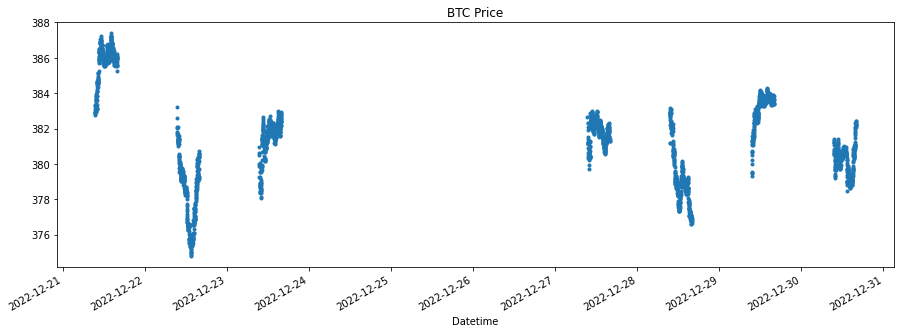

In [191]:
df['Close'].plot(style='.', figsize = (15,5), color=color_pal[0], title="BTC Price")

## Indicators

In [192]:
def EMA(data, period = 50, adjust = False):
  return data['Close'].ewm( span = period, adjust = adjust ).mean();

def RSI(data, window=14, adjust=False):
    delta = data['Close'].diff(1).dropna()
    loss = delta.copy()
    gains = delta.copy()

    gains[gains < 0] = 0
    loss[loss > 0] = 0

    gain_ewm = gains.ewm(com=window - 1, adjust=adjust).mean()
    loss_ewm = abs(loss.ewm(com=window - 1, adjust=adjust).mean())

    RS = gain_ewm / loss_ewm
    RSI = 100 - 100 / (1 + RS)

    return RSI

def HA( data ):

    hdf = data.copy()

    hdf['HA_Close']=(hdf.Open + hdf.High + hdf.Low + hdf.Close)/4


    ha_open = [ (hdf.Open[0] + hdf.Close[0]) / 2 ]
    [ ha_open.append((ha_open[i] + hdf.Close.values[i]) / 2) \
    for i in range(0, len(hdf)-1) ]
    hdf['HA_Open'] = ha_open


    hdf['HA_High']=hdf[['Open','Close','High']].max(axis=1)
    hdf['HA_Low']=hdf[['Open','Close','Low']].min(axis=1)

  

    return hdf  

def WWMA(values, n):
    """
     J. Welles Wilder's EMA 
    """
    return values.ewm(alpha=1/n, adjust=False).mean()

def ATR(df, n=14):
    data = df.copy()
    high = data['High']
    low = data['Low']
    close = data['Close']
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = WWMA(tr, n)
    return atr

def VWAP(dataframe, label='VWAP', window=14, fillna=True):
        dataframe[label] = VolumeWeightedAveragePrice(high=dataframe['High'], low=dataframe['Low'], close=dataframe["Close"], volume=dataframe['Volume'], window=window, fillna=fillna).volume_weighted_average_price()
        return dataframe[label]

# Train / Test Split

In [193]:
time_before_split = '28-12-2022'

In [194]:
train = df.loc[df.index < time_before_split]
test = df.loc[df.index >= time_before_split]

In [195]:
test

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-12-28 09:30:00,381.329987,381.739990,381.109985,381.204987,381.204987,1008958
2022-12-28 09:31:00,381.200012,381.269989,380.619995,381.170013,381.170013,209581
2022-12-28 09:32:00,381.209991,382.230896,381.209991,382.220001,382.220001,310610
2022-12-28 09:33:00,382.239990,382.630005,382.070007,382.489990,382.489990,195852
2022-12-28 09:34:00,382.480011,382.825012,382.420013,382.700012,382.700012,162803
...,...,...,...,...,...,...
2022-12-30 15:56:00,382.100006,382.279999,382.084991,382.220001,382.220001,878509
2022-12-30 15:57:00,382.209991,382.269989,382.100006,382.191589,382.191589,817383
2022-12-30 15:58:00,382.200012,382.339996,382.130005,382.250000,382.250000,1170079


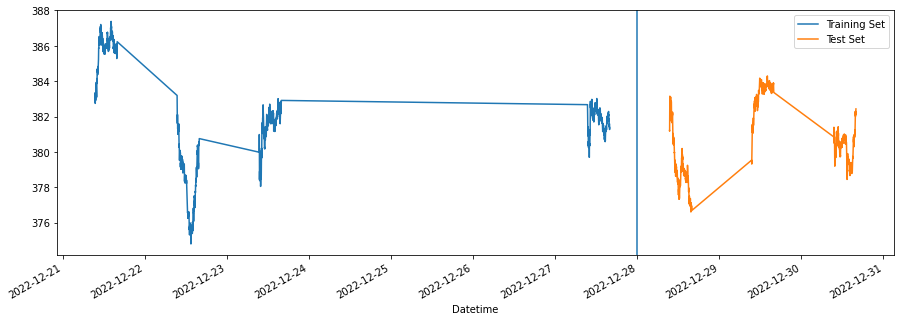

In [196]:
fig, ax = plt.subplots(figsize=(15,5))
train['Close'].plot(ax=ax, label='Training Set')
test['Close'].plot(ax=ax, label='Testing Set')
ax.axvline(time_before_split)
ax.legend(['Training Set','Test Set'])
plt.show()

## Feature Creation

In [197]:
def create_features(df):

  # Time related features 

  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.day_of_week
  df['minuteofhour'] = df.index.minute
  # df['quarter'] = df.index.quarter
  # df['month'] = df.index.month
  # df['year'] = df.index.year
  # df['dayofyear'] = df.index.dayofyear


  # Price related features

  df['next_close'] = df['Close'].shift(-1)>df['Close']
  df['close_open_diff'] = df['Close'] - df['Open']
  df['high_low_diff'] = df['High'] - df['Low']
  df['prev_close_diff'] = df['Close'] - df['Close'].shift(1)


  # Indicators related features

  df['RSI'] = pta.rsi(close = df['Close'], length=14)
  df['MACD'] = ta.trend.MACD(close = df.Close, window_slow = 26, window_fast =12, window_sign = 9, fillna = False).macd()
  df['EMA'] = ta.trend.ema_indicator(df.Close, window=100, fillna=False)

  df['EMA'] = df['Close']-df['EMA']

  df.replace({False: 0, True: 1}, inplace=True)
  df = df.dropna()
  return df

df = create_features(df)
df 

,Open,High,Low,Close,Adj Close,Volume,hour,dayofweek,minuteofhour,next_close,close_open_diff,high_low_diff,prev_close_diff,RSI,MACD,EMA
Datetime,,,,,,,,,,,,,,,,
2022-12-21 11:09:00,386.910004,386.989990,386.899994,386.970001,386.970001,67457,11,2,9,1,0.059998,0.089996,0.049988,65.758691,0.271140,1.698950
2022-12-21 11:10:00,387.000000,387.299988,387.000000,387.204987,387.204987,184339,11,2,10,0,0.204987,0.299988,0.234985,70.410140,0.284119,1.895640
2022-12-21 11:11:00,387.130005,387.209991,387.089996,387.130005,387.130005,111813,11,2,11,0,0.000000,0.119995,-0.074982,67.269935,0.285068,1.784605
2022-12-21 11:12:00,387.120789,387.170013,386.939911,387.000000,387.000000,141755,11,2,12,0,-0.120789,0.230103,-0.130005,62.098699,0.272193,1.621836
2022-12-21 11:13:00,386.989990,387.019989,386.859985,386.945007,386.945007,179951,11,2,13,0,-0.044983,0.160004,-0.054993,59.997643,0.254616,1.535817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30 15:56:00,382.100006,382.279999,382.084991,382.220001,382.220001,878509,15,4,56,0,0.119995,0.195007,0.119995,68.781481,0.413384,1.754832
2022-12-30 15:57:00,382.209991,382.269989,382.100006,382.191589,382.191589,817383,15,4,57,1,-0.018402,0.169983,-0.028412,67.774266,0.402767,1.692234
2022-12-30 15:58:00,382.200012,382.339996,382.130005,382.250000,382.250000,1170079,15,4,58,1,0.049988,0.209991,0.058411,68.786250,0.394519,1.715978


## Visualize Features

In [198]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,hour,dayofweek,minuteofhour,next_close,close_open_diff,high_low_diff,prev_close_diff,RSI,MACD,EMA
count,2630.000000,2630.000000,2630.000000,2630.000000,2630.000000,2.630000e+03,2630.000000,2630.000000,2630.000000,2630.000000,2630.000000,2630.000000,2630.000000,2630.000000,2630.000000,2630.000000
mean,381.303361,381.420021,381.185104,381.302429,381.302429,1.755000e+05,12.325475,2.741825,30.604943,0.490114,-0.000932,0.234917,-0.001707,49.439688,-0.012876,-0.087112
std,2.610064,2.597627,2.620158,2.610564,2.610564,9.780777e+05,1.858783,1.040397,17.247935,0.499997,0.163514,0.133596,0.194685,12.208803,0.238224,1.073998
min,374.970001,374.970001,374.769989,374.790009,374.790009,0.000000e+00,9.000000,1.000000,0.000000,0.000000,-0.909790,0.000000,-3.040100,10.310688,-1.166524,-3.981693
25%,379.333504,379.468353,379.220001,379.339996,379.339996,6.854000e+04,11.000000,2.000000,16.000000,0.000000,-0.089996,0.150002,-0.099091,41.232115,-0.119289,-0.628280
50%,381.369995,381.489990,381.214951,381.380005,381.380005,1.054915e+05,12.000000,3.000000,31.500000,0.000000,0.000000,0.205002,0.000000,48.718467,-0.020773,-0.030531
75%,382.679993,382.809998,382.550903,382.673767,382.673767,1.693832e+05,14.000000,4.000000,45.000000,1.000000,0.090187,0.279999,0.100006,57.807144,0.096400,0.455304
max,387.390015,387.410004,387.200012,387.380005,387.380005,4.906022e+07,16.000000,4.000000,59.000000,1.000000,1.100616,2.110016,2.851593,86.405930,1.099159,3.255718


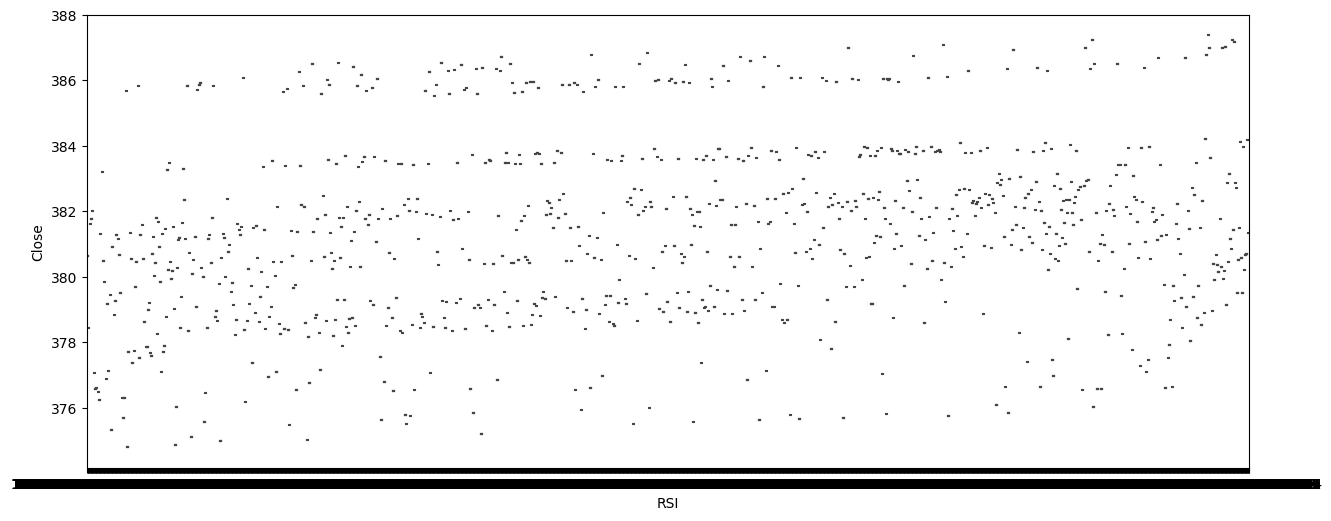

In [210]:
fig, ax = plt.subplots(figsize=(15, 6), dpi=100)

sns.boxplot(data=df, x="RSI", y="next_close", ax = ax)

## Create ML Model

In [200]:
train = create_features(train)
test = create_features(test)

<ipython-input-197-c45fad85b6b9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-197-c45fad85b6b9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.day_of_week
<ipython-input-197-c45fad85b6b9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [201]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'hour',
       'dayofweek', 'minuteofhour', 'next_close', 'close_open_diff',
       'high_low_diff', 'prev_close_diff', 'RSI', 'MACD', 'EMA'],
      dtype='object')

In [204]:
FEATURES = ['dayofweek', 'minuteofhour',
       'close_open_diff', 'high_low_diff', 'prev_close_diff', 'RSI', 'MACD', 'EMA']

TARGET =  ['next_close']

In [205]:
x_train = train[FEATURES]
x_test = test[FEATURES]

y_train = train[TARGET]
y_test = test[TARGET]

In [206]:
x_train.head()

,dayofweek,minuteofhour,close_open_diff,high_low_diff,prev_close_diff,RSI,MACD,EMA
Datetime,,,,,,,,
2022-12-21 11:09:00,2,9,0.059998,0.089996,0.049988,65.758691,0.271140,1.698950
2022-12-21 11:10:00,2,10,0.204987,0.299988,0.234985,70.410140,0.284119,1.895640
2022-12-21 11:11:00,2,11,0.000000,0.119995,-0.074982,67.269935,0.285068,1.784605
2022-12-21 11:12:00,2,12,-0.120789,0.230103,-0.130005,62.098699,0.272193,1.621836
2022-12-21 11:13:00,2,13,-0.044983,0.160004,-0.054993,59.997643,0.254616,1.535817


In [207]:
y_train

,next_close
Datetime,
2022-12-21 11:09:00,1
2022-12-21 11:10:00,0
2022-12-21 11:11:00,0
2022-12-21 11:12:00,0
2022-12-21 11:13:00,0
...,...
2022-12-27 15:55:00,0
2022-12-27 15:56:00,0
2022-12-27 15:57:00,0


In [208]:
reg = xgb.XGBRegressor(n_estimators = 2000, early_stopping_rounds = 50, learning_rate = 0.0002)
reg.fit(x_train, y_train, eval_set=[(x_train, y_train),(x_test, y_test)], verbose=True,)

[09:34:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.499997	validation_1-rmse:0.5
[1]	validation_0-rmse:0.499995	validation_1-rmse:0.5
[2]	validation_0-rmse:0.499992	validation_1-rmse:0.499999
[3]	validation_0-rmse:0.499989	validation_1-rmse:0.499999
[4]	validation_0-rmse:0.499986	validation_1-rmse:0.499999
[5]	validation_0-rmse:0.499984	validation_1-rmse:0.499999
[6]	validation_0-rmse:0.499981	validation_1-rmse:0.499998
[7]	validation_0-rmse:0.499978	validation_1-rmse:0.499998
[8]	validation_0-rmse:0.499976	validation_1-rmse:0.499998
[9]	validation_0-rmse:0.499973	validation_1-rmse:0.499998
[10]	validation_0-rmse:0.49997	validation_1-rmse:0.499997
[11]	validation_0-rmse:0.499968	validation_1-rmse:0.499997
[12]	validation_0-rmse:0.499965	validation_1-rmse:0.499997
[13]	validation_0-rmse:0.499962	validation_1-rmse:0.499997
[14]	validation_0-rmse:0.49996	validation_1-rmse:0.499997
[15]	valid

XGBRegressor(early_stopping_rounds=50, learning_rate=0.0002, n_estimators=2000)

## Feature Importance

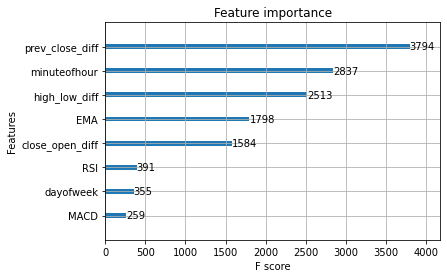

In [209]:
xgb.plot_importance(reg)

## Prediction

In [212]:
test['Prediction'] = reg.predict(x_test)
df = df.merge(test[['Prediction']], how='left', left_index = True, right_index=True)
df.tail()

<ipython-input-212-0b4a012bc36e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = reg.predict(x_test)


,Open,High,Low,Close,Adj Close,Volume,hour,dayofweek,minuteofhour,next_close,close_open_diff,high_low_diff,prev_close_diff,RSI,MACD,EMA,Prediction_x,Prediction_y
Datetime,,,,,,,,,,,,,,,,,,
2022-12-30 15:56:00,382.100006,382.279999,382.084991,382.220001,382.220001,878509,15,4,56,0,0.119995,0.195007,0.119995,68.781481,0.413384,1.754832,0.483384,0.483384
2022-12-30 15:57:00,382.209991,382.269989,382.100006,382.191589,382.191589,817383,15,4,57,1,-0.018402,0.169983,-0.028412,67.774266,0.402767,1.692234,0.528593,0.528593
2022-12-30 15:58:00,382.200012,382.339996,382.130005,382.250000,382.250000,1170079,15,4,58,1,0.049988,0.209991,0.058411,68.786250,0.394519,1.715978,0.512266,0.512266
2022-12-30 15:59:00,382.260010,382.579987,382.059998,382.429993,382.429993,3815291,15,4,59,0,0.169983,0.519989,0.179993,71.732106,0.397919,1.858427,0.459589,0.459589
2022-12-30 16:00:00,382.429993,382.429993,382.429993,382.429993,382.429993,0,16,4,0,0,0.000000,0.000000,0.000000,71.732106,0.396048,1.821626,0.502507,0.502507


<ipython-input-217-c6898bc02530>:3: UserWarning: Legend does not support 'T' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Truth Data",'Prediction')
<ipython-input-217-c6898bc02530>:3: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Truth Data",'Prediction')
<ipython-input-217-c6898bc02530>:3: UserWarning: Legend does not support 'u' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Truth Data",'Prediction')
<ipython-input-217-c6898bc02530>:3: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://

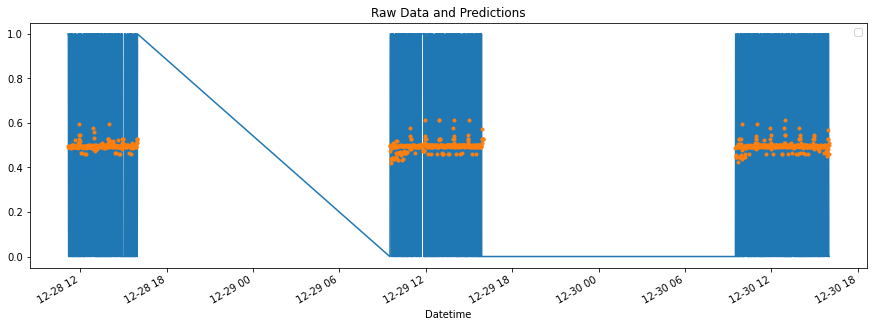

In [217]:
ax = test['next_close'].plot(figsize = (15,5))
test[['Prediction']].plot(ax=ax, style=".")
plt.legend("Truth Data",'Prediction')
ax.set_title("Raw Data and Predictions")
plt.show()

In [223]:
test[test['Prediction']<0.45]

,Open,High,Low,Close,Adj Close,Volume,hour,dayofweek,minuteofhour,next_close,close_open_diff,high_low_diff,prev_close_diff,RSI,MACD,EMA,Prediction
Datetime,,,,,,,,,,,,,,,,,
2022-12-29 09:34:00,379.529999,380.320007,379.480804,379.989990,379.989990,384862,9,3,34,1,0.459991,0.839203,0.479889,80.052468,0.620301,2.204580,0.419665
2022-12-29 09:35:00,379.999298,380.299988,379.839996,380.214996,380.214996,221042,9,3,35,1,0.215698,0.459991,0.225006,81.196278,0.718563,2.381476,0.440039
2022-12-29 09:36:00,380.220001,380.570007,380.089996,380.500000,380.500000,172221,9,3,36,1,0.279999,0.480011,0.285004,82.560368,0.810095,2.613678,0.440039
2022-12-29 09:37:00,380.510010,380.779999,380.420013,380.679993,380.679993,244116,9,3,37,1,0.169983,0.359985,0.179993,83.380360,0.886935,2.738350,0.440039
2022-12-29 09:41:00,381.250000,381.329987,381.100006,381.279999,381.279999,190740,9,3,41,1,0.029999,0.229980,0.029999,85.156845,1.059322,3.103991,0.444666
2022-12-29 09:42:00,381.279999,381.350006,381.149994,381.325012,381.325012,243495,9,3,42,1,0.045013,0.200012,0.045013,85.359987,1.078036,3.086648,0.444666
2022-12-29 09:43:00,381.329987,381.589996,381.329987,381.559998,381.559998,266665,9,3,43,0,0.230011,0.260010,0.234985,86.405930,1.099159,3.255858,0.440039
2022-12-29 09:45:00,381.100006,381.350006,381.049988,381.148895,381.148895,261136,9,3,45,1,0.048889,0.300018,0.061401,75.292453,1.031865,2.734400,0.444666
2022-12-29 09:46:00,381.149994,381.319397,381.059998,381.269989,381.269989,188116,9,3,46,1,0.119995,0.259399,0.121094,76.221928,1.003423,2.798949,0.440039


In [220]:
test[test['Prediction']>0.55]

,Open,High,Low,Close,Adj Close,Volume,hour,dayofweek,minuteofhour,next_close,close_open_diff,high_low_diff,prev_close_diff,RSI,MACD,EMA,Prediction
Datetime,,,,,,,,,,,,,,,,,
2022-12-28 11:56:00,378.220001,378.359985,378.140015,378.230011,378.230011,86465,11,2,56,0,0.010010,0.219971,0.005005,34.684186,-0.182669,-1.339376,0.593531
2022-12-28 12:54:00,379.049988,379.100006,378.950104,379.059998,379.059998,87577,12,2,54,1,0.010010,0.149902,0.018494,69.633290,0.285698,0.457431,0.576279
2022-12-28 12:56:00,379.200012,379.200012,378.859985,378.869904,378.869904,115710,12,2,56,1,-0.330109,0.340027,-0.330200,58.870706,0.274271,0.250445,0.559524
2022-12-28 13:59:00,378.670013,378.798401,378.653198,378.670013,378.670013,50084,13,2,59,1,0.000000,0.145203,-0.009979,42.143375,-0.102264,-0.300753,0.593531
2022-12-29 10:54:00,382.989990,383.010101,382.910004,382.950012,382.950012,213544,10,3,54,1,-0.039978,0.100098,0.010010,56.301856,0.086055,1.495124,0.576279
2022-12-29 11:57:00,383.950012,384.000000,383.880005,383.940002,383.940002,78845,11,3,57,1,-0.010010,0.119995,-0.019989,65.323644,0.233024,1.154799,0.611722
2022-12-29 12:56:00,383.860107,383.934998,383.820007,383.860107,383.860107,37285,12,3,56,0,0.000000,0.114990,0.005096,57.009336,0.041005,0.408866,0.611722
2022-12-29 12:57:00,383.860107,383.899994,383.829987,383.850098,383.850098,37651,12,3,57,1,-0.010010,0.070007,-0.010010,56.479303,0.045797,0.390958,0.611722
2022-12-29 13:53:00,383.669891,383.769989,383.649994,383.674988,383.674988,40018,13,3,53,1,0.005096,0.119995,0.004974,50.643960,0.023138,0.100236,0.576279
